In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

# Process the image and resize them to required size

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 180
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Preparing Training and Testing Data

In [3]:
train = get_training_data('C:\\Users\\Chowdary\\datasets\\chest_xray\\train')
test = get_training_data('C:\\Users\\Chowdary\\datasets\\chest_xray\\test')
val = get_training_data('C:\\Users\\Chowdary\\datasets\\chest_xray\\val')

In [4]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3785
Normal: 1251
Pneumonia - Normal: 2534


# Visualising Training Images

PNEUMONIA


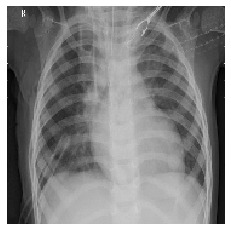

In [5]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

# merging validation data into train data
Firstly I thought of having separate validation folder and later on my experiments, Came to know that we can even merge validation data into train data if we don't have enough samples, So incorporating it now

In [6]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

# Scaling data

In [7]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

# Data Augmentation
for balancing imbalance or disproportions in dataset

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

# Building model

In [9]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 256)     2560      
_________________________________________________________________
activation (Activation)      (None, 180, 180, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 256)       360       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        147520    
_________________________________________________________________
activation_1 (Activation)    (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0

# Training Our model

In [11]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10),
                    callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
375/375 [==============================] - 1478s 4s/step - loss: 0.6282 - acc: 0.7139 - val_loss: 0.9921 - val_acc: 0.7428
Epoch 2/15
375/375 [==============================] - 1449s 4s/step - loss: 0.4558 - acc: 0.7718 - val_loss: 0.3680 - val_acc: 0.8314
Epoch 3/15
375/375 [==============================] - 1427s 4s/step - loss: 0.4083 - acc: 0.8044 - val_loss: 0.3245 - val_acc: 0.8741
Epoch 4/15
375/375 [==============================] - 1395s 4s/step - loss: 0.3765 - acc: 0.8276 - val_loss: 0.3066 - val_acc: 0.8698
Epoch 5/15
375/375 [==============================] - 1352s 4s/step - loss: 0.3496 - acc: 0.8417 - val_loss: 0.2810 - val_acc: 0.8805
Epoch 6/15
375/375 [==============================] - 1396s 4s/step - loss: 0.3252 - acc: 0.8513 - val_loss: 0.2446 - val_acc: 0.9039
Epoch 7/15
375/375 [==============================] - 1567s 4s/step - loss: 0.3132 - acc: 0.8588 - val_loss: 0.3335 - val_acc: 0.8517
Epoch 8/15
375/375 [==============================] - 1490s 4s

In [12]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 93s 3s/step - loss: 0.1955 - acc: 0.9164


[0.19551008939743042, 0.9163822531700134]

Prepare data for precision vs. recall and ROC

In [18]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

In [19]:
predictions = model.predict(X_test)

# Setting threshold to our model

In [20]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [21]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9172354948805461
Precision on testing set: 0.9204892966360856
Recall on testing set: 0.8091397849462365


# Plotting confusion matrix

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

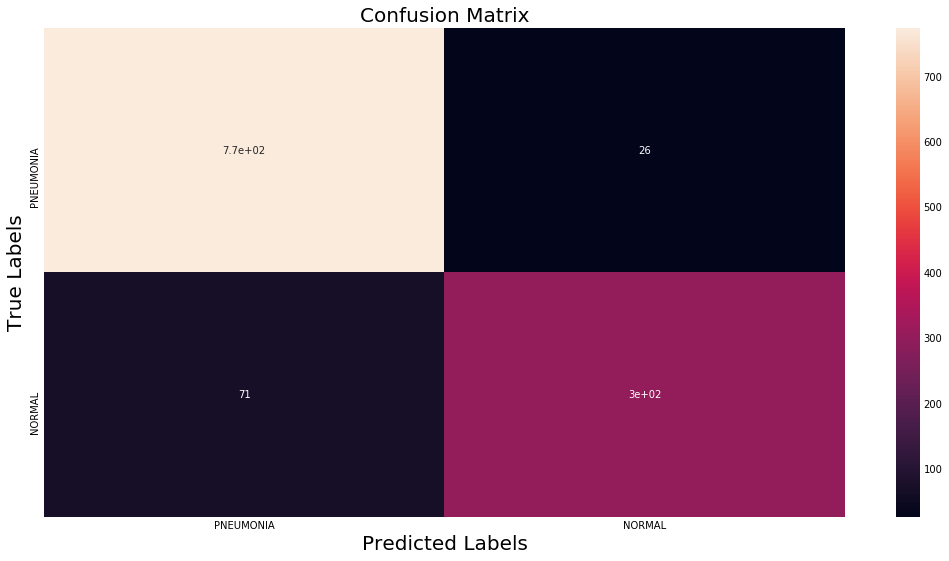

In [22]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# predicting some models from train data

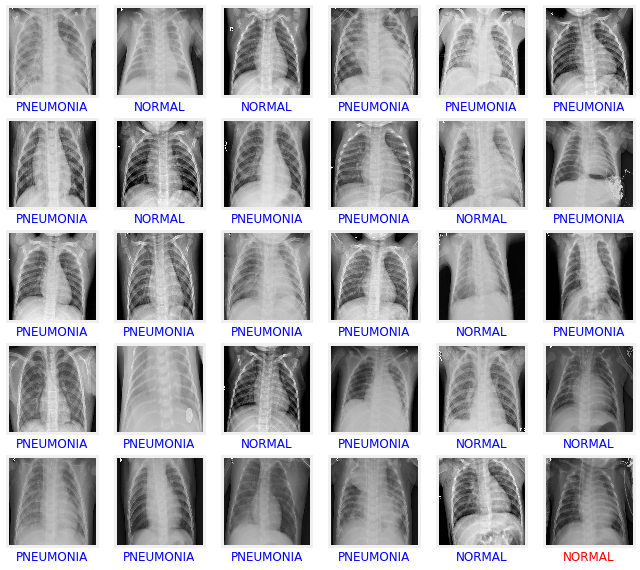

In [23]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

In [24]:
model.save('C:\\Users\\Chowdary\\datasets\\saved_models\\myProjectmodel2.h5')
model.save('C:\\Users\\Chowdary\\datasets\\saved_models\\myProjectmodel3.pb')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Chowdary\datasets\saved_models\myProjectmodel3.pb\assets
